# Introduction
The goal of this notebook is to model an item-to-item collaborative filter, that, for a given item, recommends other items that share the same viewers. 

*Data*
- EventId -- A unique identifier for this event in the form of a SHA256 hash
- MediaId -- A unique identifier for watched Media items as an integer
- UserId -- A unique identifier for a user-account as an integer
- Timestamp -- A Unix/POSIX Epoch time representation of the client-side time
- DateTime -- An ISO-8601 formatted representation of the client-side time
- EventType -- The type of view-event send to the server
-- waypoint -- denoting a 30 seconds watched interval
-- streamstart -- denoting the start of a stream
-- streamstop -- denoting a client-initiated stop of stream
-- streamend -- denoting the end of the media item is reached, should occur once for each user-
item combination

In [1]:
from collections import Counter
import gzip
import joblib
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import timeit

pd.options.mode.chained_assignment = None

FONTSIZE = 15
LOCAL_PATH = 'data/'
FILE_PATH = LOCAL_PATH + "noisy_mock_events.gz"

# Process stream events
The following steps were done to process the data:
- Read data and store as pd.DataFrame.
- Group by user and items, aggregate the streamlength.
- Filter streams that don't contain StreamStart and StreamStop, because StreamStop is related to user interaction.  

In [2]:
# get keys
with gzip.open(FILE_PATH, "r") as events_file:
    while line := events_file.readline():
        event = json.loads(line)
        # discard EventId
        keys = list(event.keys())[1:]
        break

# get values
collab_raw_timeseries = []

start_time = timeit.default_timer()

with gzip.open(FILE_PATH, "r") as events_file:
    while line := events_file.readline():
        event = json.loads(line)
        # discard EventId values
        collab_raw_timeseries.append(list(event.values())[1:])

print(f'Took {timeit.default_timer()-start_time:.2f} seconds.')

df = pd.DataFrame(collab_raw_timeseries, columns = keys)

Took 45.82 seconds.


# Preprocessing

In [3]:
# Incorrect types: Timestamp is int, and UserId is string. 
df.dtypes

UserId       object
MediaId       int64
Timestamp     int64
DateTime     object
EventType    object
dtype: object

In [4]:
print("Missing values :  ", df.isnull().sum().values.sum())

Missing values :   0


In [5]:
# replace id's that are strings instead of int
df['UserId'] = df['UserId'].apply(lambda x: x if isinstance(x, int) else int(x[1:-1]))

In [6]:
# convert timestamp from int to datetime object, such that we can substract dates
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [7]:
# limit memory
df = df[df['EventType'] != 'waypoint']

In [8]:
# a list of events will indicate if users missed particular event types.
# convert streamlength to minutes to make values interpretable.
df_media_users_grouped = df.groupby(['MediaId', 'UserId'], as_index=False).agg(
    EventTypeList = pd.NamedAgg('EventType', lambda x: list(x)),
    EventTimesList = pd.NamedAgg('DateTime', lambda x: list(x)),
    StreamLength = pd.NamedAgg(
        'DateTime', lambda x: (x.iloc[-1] - x.iloc[0]).total_seconds() // 60
    )
)

Text(0.5, 1.0, 'Times between events vs total stream length')

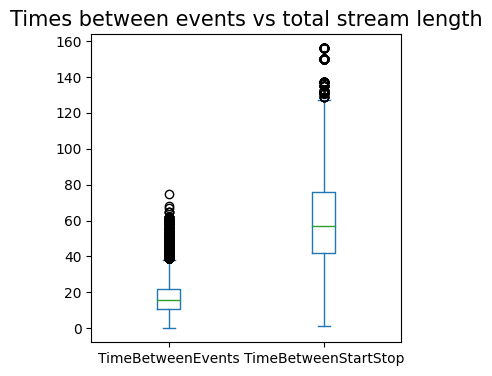

In [14]:
# StreamEnd means that the end of a stream is reached.
# However, there are waypoints between start-end, end-end, end-stop.
# Time between events on average is ~18 min, while total length ~58 min.
contains_start = df_media_users_grouped['EventTypeList'].apply(lambda x: 'streamstart' in x)
contains_end = df_media_users_grouped['EventTypeList'].apply(lambda x: 'streamend' in x)
contains_stop = df_media_users_grouped['EventTypeList'].apply(lambda x: 'streamstop' in x)

# plot difference in time between events, and total length, i.e. start-stop.
_, ax = plt.subplots(figsize=(4,4))
df_start_end_stop = df_media_users_grouped[contains_start & contains_end & contains_stop]
df_start_end_stop["TimeBetweenEvents"] = df_start_end_stop["EventTimesList"].apply(lambda x: np.array(x)).apply(lambda x: (x[1:] - x[:-1]).mean().total_seconds() // 60)
df_start_end_stop["TimeBetweenStartStop"] = df_start_end_stop["EventTimesList"].apply(lambda x: np.array(x)).apply(lambda x: (x[-1] - x[0]).total_seconds() // 60)
df_start_end_stop.plot.box(column=["TimeBetweenEvents", "TimeBetweenStartStop"], ax = ax)
ax.set_title("Times between events vs total stream length", fontsize=FONTSIZE)

In [15]:
# filter out if start and stop are not in EventType, because stream length (the rating) will be between start and stop
contains_start = df_media_users_grouped['EventTypeList'].apply(lambda x: 'streamstart' in x)
contains_stop = df_media_users_grouped['EventTypeList'].apply(lambda x: 'streamstop' in x)
df_media_users_grouped = df_media_users_grouped[contains_start & contains_stop]

In [18]:
# continue with the filtered group by object
df = df_media_users_grouped[["MediaId", "UserId", "StreamLength"]]
df.head()

,MediaId,UserId,StreamLength
1,1,2,47.0
2,1,5,47.0
3,1,6,47.0
4,1,10,47.0
5,1,13,35.0


In [19]:
# just checking if streamlength is less than 0
len(df[df["StreamLength"] < 0])

0

In [20]:
df.dtypes

MediaId           int64
UserId            int64
StreamLength    float64
dtype: object

# Key insights 

In [21]:
n_ratings = len(df)
n_media = len(df['MediaId'].unique())
n_users = len(df['UserId'].unique())
  
print(f"Number of ratings: {n_ratings}")
print(f"Number of unique media: {n_media}")
print(f"Number of unique users: {n_users}")
 
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per media: {round(n_ratings/n_media, 2)}")

Number of ratings: 78799
Number of unique media: 1672
Number of unique users: 943
Average ratings per user: 83.56
Average ratings per media: 47.13


In [22]:
# dedicated users
user_freq = df[['UserId', 'MediaId']].groupby('UserId').count().reset_index()
user_freq.columns = ['UserId', 'n_views']
user_freq.sort_values('n_views', ascending=False).head(3)

,UserId,n_views
654,655,670
404,405,669
12,13,500


In [23]:
# popular media 
item_freq = df[['UserId', 'MediaId']].groupby('MediaId').count().reset_index()
item_freq.columns = ['MediaId', 'n_views']
item_freq.sort_values('n_views', ascending=False).head(3)

,MediaId,n_views
293,294,439
287,288,393
257,258,377


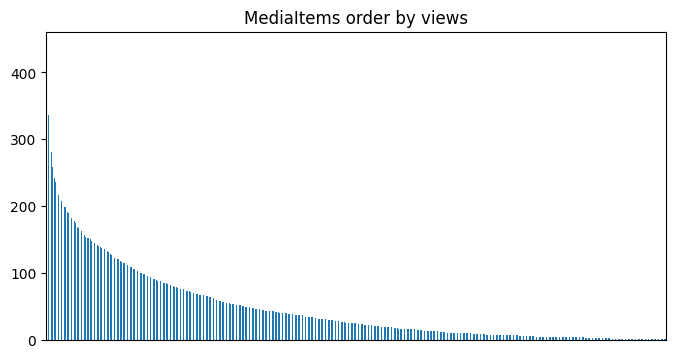

In [24]:
# Many media items distribution has a relatively long tale.
# Useful if one wants to increase diversity.
_, ax = plt.subplots(figsize=(8, 4))
item_freq.sort_values('n_views', ascending=False)['n_views'].plot.bar(ax=ax, width=.5)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_title('MediaItems order by views');

In [25]:
# Find Lowest and Highest rated media:
mean_rating = df.groupby('MediaId')[['StreamLength']].mean()
# Lowest rated media
lowest_rated = mean_rating['StreamLength'].idxmin()
lowest_rated_MediaId = df.loc[df['MediaId'] == lowest_rated]['MediaId']
print(f'Lowest rated MediaId: {lowest_rated_MediaId.unique()} by {len(lowest_rated_MediaId)} users.')

Lowest rated MediaId: [1063] by 29 users.


In [26]:
# Highest rated media
highest_rated = mean_rating['StreamLength'].idxmax()
highest_rated_MediaId = df.loc[df['MediaId'] == highest_rated]['MediaId']
print(f'Lowest rated MediaId: {highest_rated_MediaId.unique()} by {len(highest_rated_MediaId)} users.')

Lowest rated MediaId: [1593] by 1 users.


Text(0.5, 1.0, 'Stream length in minutes')

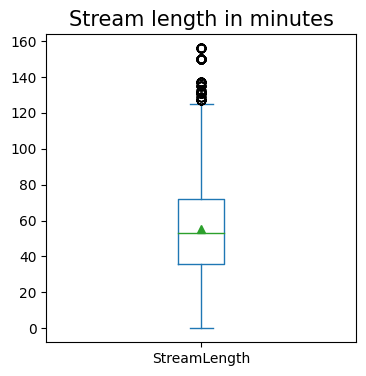

In [27]:
# Outliers are visualized by black circles, indicating that they 
_, ax = plt.subplots(figsize=(4, 4))
df['StreamLength'].plot.box(ax=ax, showmeans=True)
ax.set_title('Stream length in minutes', fontsize=FONTSIZE)

# Processing ratings

In [28]:
stats = df['StreamLength'].describe()
stats

count    78799.000000
mean        55.154190
std         26.025976
min          0.000000
25%         36.000000
50%         53.000000
75%         72.000000
max        156.000000
Name: StreamLength, dtype: float64

In [29]:
# outliers can happen due to errors in data collection
# they can also distort the similarity computation

# Calculate the boundaries for outliers
q1 = stats['25%']
q3 = stats['75%']
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
df = df[(df['StreamLength'] >= lower_bound) & (df['StreamLength'] <= upper_bound)]

In [30]:
df = df.rename(columns={"StreamLength": "Rating"})

Text(0.5, 1.0, 'Rating')

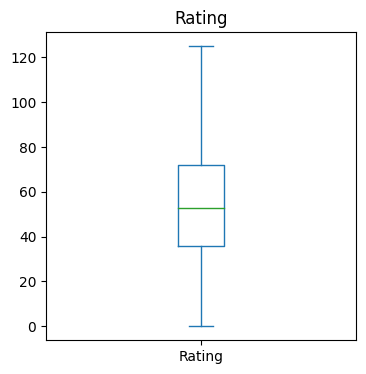

In [31]:
_, ax = plt.subplots(figsize=(4, 4))
df["Rating"].plot.box(ax=ax)
ax.set_title("Rating")

# Item-to-item collaborative filter
A kNN will be used to find similar items based on the ratings from users. 
- Metric: The similarity metric will be 'cosine distance'. Unlike 'euclidean distance' it takes the vector-norm into account, so if two media items differ in total video length, that won't affect the rating. It's also suitable for floats.
- Algorithm: 'Ball-tree' is more efficient than 'brute' for structering the data, and unlike a 'KD-tree' it is suitable for high-dimensional data.

👆 Notes:
- kNN requires to store the item-user matrix, which can take up a lot of memory. Alternative methods use matrix vectorization to prevent this. 
- A [popularity bias](https://realpython.com/build-recommendation-engine-collaborative-filtering/) when items that are frequently viewed are recommended more often, because they appear more similar to other items. A way to mitigate this is to substitue 0's by the average rating or to use the 'centered cosine'. 

In [32]:
# We need a mapper
print(df["UserId"].max(), len(df["UserId"].unique()))
print(df["MediaId"].max(), len(df["MediaId"].unique()))

943 943
1682 1671


In [33]:
def create_matrix(df: pd.DataFrame):
    """
    Create compressed Sparse Row matrix with M-item-rows and N-user-columns.
    Media and User mappers are used to map id's to indices.
    params: pd.DataFrame
    returns: scipy.sparse.csr_matrix for the compressed matrix, and the mappings (dict)
    """
    N = len(df['UserId'].unique())
    M = len(df['MediaId'].unique())

    # Map Ids to indices
    user_mapper = dict(zip(np.unique(df["UserId"]), list(range(N))))
    media_mapper = dict(zip(np.unique(df["MediaId"]), list(range(M))))

    # Map indices to IDs
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["UserId"])))
    media_inv_mapper = dict(zip(list(range(M)), np.unique(df["MediaId"])))

    user_index = [user_mapper[i] for i in df['UserId']]
    media_index = [media_mapper[i] for i in df['MediaId']]

    X = csr_matrix((df["Rating"], (media_index, user_index)), shape=(M, N))

    return X, user_mapper, media_mapper, user_inv_mapper, media_inv_mapper

Note, Ball Trees as the algorithm to structure the input data, are suitable for high-dimensional data and more efficient than brute force.

In [34]:
def get_dimension_reduction_model(X, k, metric='cosine'):
    """
    Trains a k-nearest neighbors algorithm to reduce the dimension of csr matrix.
    """
    k += 1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    return kNN

In [35]:
k = 10

X, user_mapper, media_mapper, user_inv_mapper, media_inv_mapper = create_matrix(df)
model = get_dimension_reduction_model(X, k)

# These are required to find similiar items.
model.media_mapper = media_mapper
model.media_inv_mapper = media_inv_mapper

In [36]:
joblib.dump(model, 'final_model.joblib')

['final_model.joblib']

# Validation
To check for popularity bias, i.e. the system tends to recommend popular items, we can check if similar items are also the popular items.

In [41]:
def find_similar_items(item_id: int, model: NearestNeighbors, k: int):
    """
    Find similar items using KNN.
    :param item_id: The id of the item
    :param model: A dimension reduction model used to find similar items
    :param k: The number of similar items returned.
    :returns List with similar ids
    """
    neighbour_ids = []

    item_id = model.media_mapper[item_id]
    item_vec = model._fit_X[item_id]
    k += 1
    item_vec = item_vec.reshape(1, -1)
    neighbour = model.kneighbors(item_vec, return_distance=False)

    for i in range(k):
        n = neighbour.item(i)
        neighbour_ids.append(model.media_inv_mapper[n])
    # We don't want to recommend this item_id itself
    neighbour_ids.pop(0)
    return neighbour_ids[:k]

In [42]:
# given all possible items, compute similar items by the model
k = 3
similar_items = []

for media_id in media_mapper.keys():
    similar_ids = find_similar_items(media_id, model, k)
    similar_items.extend(similar_ids)

In [50]:
# most recommended media by model
[k for k,v in Counter(similar_items).most_common()[:5]]

[204, 1557, 1575, 1587, 405]

In [51]:
# most popular media by views
item_freq.sort_values('n_views', ascending=False)["MediaId"].values[:5]

array([294, 288, 258, 121, 286])